# Pipeline for CNN with P300 data

## Environment
conda create -n P300_pipeline python=3.11 \
conda activate P300_pipeline

## Packages

pip install \
  "numpy<2" \
  "moabb<1.4" \
  "pyriemann<0.9" \
  braindecode \
  mne \
  scipy \
  pandas \
  scikit-learn\
  optuna


python -m pip install -U ipykernel\
python -m ipykernel install --user --name P300_pipeline --display-name "Python (P300_pipeline)"


## Dataset

In [39]:
from braindecode.datasets import MOABBDataset

# all subjects (BNCI2014_009 has 10 subjects)
dataset_full = MOABBDataset(dataset_name="BNCI2014_009")

print("Number of recordings:", len(dataset_full.datasets))
print(dataset_full.description.head())
print(dataset_full.description.columns)


Number of recordings: 30
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
3        2       0   0
4        2       1   0
Index(['subject', 'session', 'run'], dtype='object')


In [40]:
from braindecode.datasets import MOABBDataset

subject_id = 1
dataset = MOABBDataset(dataset_name="BNCI2014_009", subject_ids=[subject_id])

### Inspect dataset

In [4]:
# see subjects and their sessions
import pandas as pd
pd.set_option("display.max_columns", None)

dataset_full.description.groupby("subject").size()

subject
1     3
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    3
dtype: int64

In [5]:
# One subject → one or more MNE Raw objects
raw = dataset.datasets[0].raw

print(raw)

# Channel names
print(raw.ch_names)

# Channel types (EEG, stim, etc.)
print(raw.get_channel_types())


<RawArray | 18 x 50184 (196.0 s), ~6.9 MiB, data loaded>
['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4', 'Target stim', 'Flash stim']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim', 'stim']


In [6]:
import mne
#  Number of channels
print("n_channels:", raw.info["nchan"])

# Sampling frequency
print("sfreq:", raw.info["sfreq"])

# Pick only EEG channels
eeg_picks = mne.pick_types(raw.info, eeg=True, stim=False)
print("EEG channel indices:", eeg_picks)
print("EEG channel names:", [raw.ch_names[i] for i in eeg_picks])


n_channels: 18
sfreq: 256.0
EEG channel indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
EEG channel names: ['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4']


In [7]:
# Get EEG data as numpy array (shape: n_channels x n_samples))
data = raw.get_data(picks="eeg")

print("EEG data shape:", data.shape)


EEG data shape: (16, 50184)


In [8]:
# check events and labels 
events, event_id = mne.events_from_annotations(raw)

print("Event IDs:", event_id)
print("First 10 events:\n", events[:10])

Used Annotations descriptions: ['NonTarget', 'Target']
Event IDs: {'NonTarget': 1, 'Target': 2}
First 10 events:
 [[1544    0    1]
 [1608    0    1]
 [1672    0    2]
 [1736    0    1]
 [1800    0    1]
 [1864    0    1]
 [1928    0    1]
 [1992    0    1]
 [2056    0    2]
 [2120    0    1]]


Using matplotlib as 2D backend.


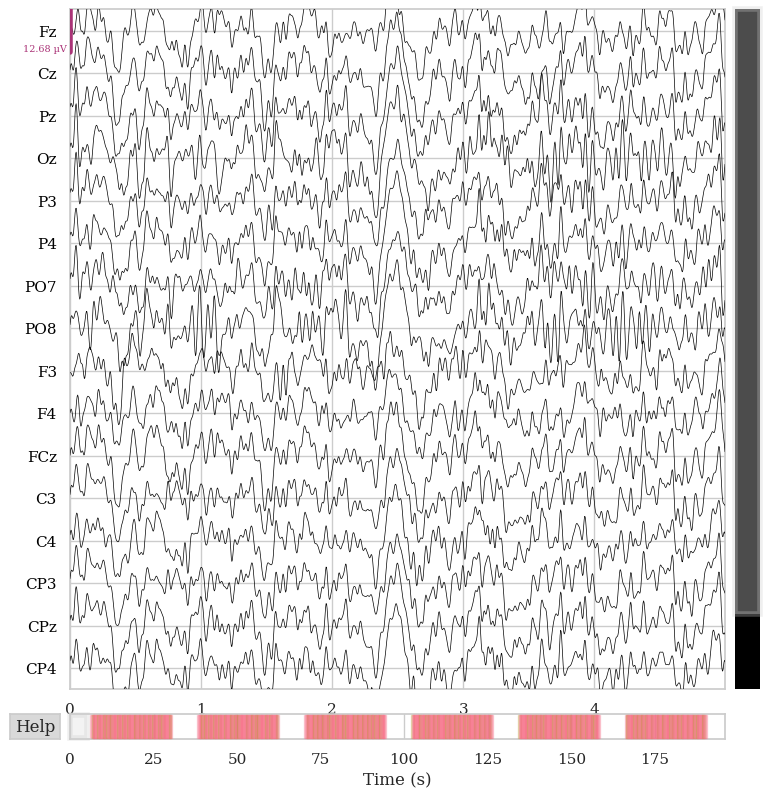

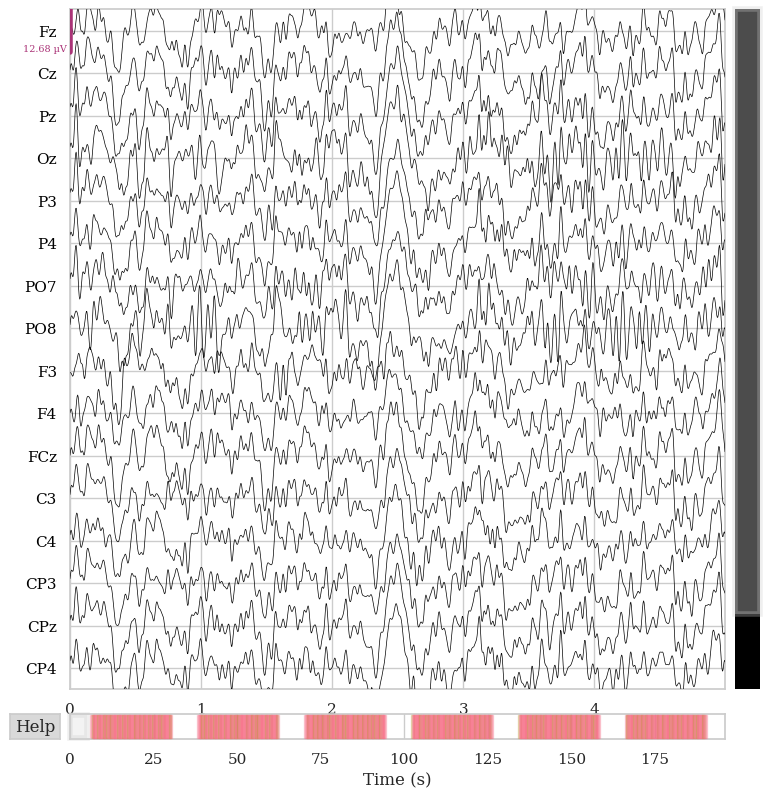

In [9]:
# Plot a few seconds of EEG
raw.plot(n_channels=16, duration=5, scalings="auto")


## Preprocessing

In [41]:
import numpy as np
from braindecode.preprocessing import (
    Preprocessor,
    preprocess,
)

# bandpass filter that matches dataset 
low_cut_hz = 0.1
high_cut_hz = 20.0
factor = 1e6 # to convert from V to uV
#resample_sfreq = 128  # set to none if you want to keep it at 256 Hz

def to_microvolts(data):
    return data * factor

preprocessors = [
    # keep only EEG channels
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),
    # scale the data
    Preprocessor(to_microvolts),
    # bandpass filter for ERPs
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),
]

# apply the preprocessors to the dataset
preprocess(dataset, preprocessors, n_jobs=-1)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8449 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed

## Creating trial windows

In [42]:
from braindecode.preprocessing import create_windows_from_events

# read sampling frequency from the data
sfreq = dataset.datasets[0].raw.info["sfreq"]
print("sampling frequency:", sfreq)

# trial window setting for P300
tmin = 0.0
tmax = 0.8 # P300 window 300ms to 800ms

start_offset = int(np.round(tmin * sfreq))
stop_offset = int(np.round(tmax * sfreq))

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=start_offset,
    trial_stop_offset_samples=stop_offset,
    preload=True,
)

print(windows_dataset)
print(windows_dataset.description.head())
print(windows_dataset.description.columns)


sampling frequency: 256.0
Used Annotations descriptions: ['NonTarget', 'Target']
Used Annotations descriptions: ['NonTarget', 'Target']
Used Annotations descriptions: ['NonTarget', 'Target']
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
Index(['subject', 'session', 'run'], dtype='object')


In [43]:
# count number of target and non-target trials
y = np.array([windows_dataset[i][1] for i in range(len(windows_dataset))])

n_nontarget = np.sum(y == 0)
n_target = np.sum(y == 1)

print(f"NonTarget (0): {n_nontarget}")
print(f"Target (1): {n_target}")
print(f"Total windows: {len(y)}")



NonTarget (0): 1440
Target (1): 288
Total windows: 1728


## Splitting the dataset into training and validation sets

In [44]:
# check how many sessions 
print(windows_dataset.description["session"].unique())

['0' '1' '2']


In [45]:
from braindecode.datasets import BaseConcatDataset

# Split dataset into training and test based on sessions
splits = windows_dataset.split("session")
session_keys = sorted(list(splits.keys()), key=str)

print("Available sessions:", session_keys)

if len(session_keys) < 2:
    raise RuntimeError("Not enough sessions found for a cross-session split.")

train_keys = session_keys[:-1]
test_key = session_keys[-1]

# Collect datasets for training sessions
train_datasets = []
for k in train_keys:
    train_datasets.extend(splits[k].datasets)

# Build new BaseConcatDataset
train_set = BaseConcatDataset(train_datasets)

# Test set is just one split
test_set = splits[test_key]

print("Train windows:", len(train_set), "Test windows:", len(test_set))
print("Train sessions:", train_keys, "Test session:", test_key)


Available sessions: ['0', '1', '2']
Train windows: 1152 Test windows: 576
Train sessions: ['0', '1'] Test session: 2


In [46]:
# count number of target and non-target trials in train and test sets
def get_labels_from_base_concat(dataset):
    labels = []
    for ds in dataset.datasets:
        labels.extend(ds.y)
    return np.array(labels)

y_train = get_labels_from_base_concat(train_set)
y_test = get_labels_from_base_concat(test_set)

print("Training set:")
print("  NonTarget:", np.sum(y_train == 0))
print("  Target:", np.sum(y_train == 1))

print("Test set:")
print("  NonTarget:", np.sum(y_test == 0))
print("  Target:", np.sum(y_test == 1))



Training set:
  NonTarget: 960
  Target: 192
Test set:
  NonTarget: 480
  Target: 96


## Create groups for cros validation (session-based)

In [47]:
# For Braindecode BaseConcatDataset, this gives per-window metadata (one row per window)
train_meta = train_set.get_metadata()

print("Metadata columns:", train_meta.columns.tolist())
print("Unique sessions in TRAIN:", train_meta["session"].unique())

# Groups must have length == number of windows
groups = train_meta["session"].to_numpy()

n_sessions = len(np.unique(groups))
print("Number of sessions in TRAIN:", n_sessions)

if n_sessions < 2:
    raise RuntimeError("Need at least 2 sessions in training set for session-based CV.")

Metadata columns: ['i_window_in_trial', 'i_start_in_trial', 'i_stop_in_trial', 'target', 'subject', 'session', 'run']
Unique sessions in TRAIN: ['0' '1']
Number of sessions in TRAIN: 2


In [48]:
from sklearn.model_selection import GroupKFold
from skorch.callbacks import EpochScoring

# define cross validation splitter
# if you have 2 training sessions, this becomes 2-fold GroupKFold (each session is used once as validation)
cv = GroupKFold(n_splits=n_sessions)

# callbacks for logging
train_acc_cb = EpochScoring(scoring="accuracy", on_train=True, name="train_accuracy")
train_bacc_cb = EpochScoring(scoring="balanced_accuracy", on_train=True, name="train_bacc")

# ShallowFBSNet

### Model from Schirrmeister et al., 2017

Adapted from https://braindecode.org/stable/auto_examples/model_building/plot_bcic_iv_2a_moabb_trial.html

## Build the model

In [16]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available() # check if GPU is available and if true chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
# set random seed to be able to roughly reproduce results
# note that with cudnn benchmark set to true, GPU indeterminism
# may still make results substantially different between runs
# to obtain more consistent results at the cost of increased computation time,
# you can set the cudnn_benchmark to False in 'set_random_seed'
# or remove 'torch.backends.cudnn.benchmark = True' 
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

# for P300, infer number of classes from labels in train set
y_train = train_set.y if hasattr(train_set, "y") else np.array([train_set[i][1] for i in range(len(train_set))])
classes = np.unique(y_train)
n_classes = len(classes)

# Same as tutorial: infer input dims from one batch element
n_chans = train_set[0][0].shape[0]
n_times = train_set[0][0].shape[1]

print("Detected classes:", classes, "n_classes:", n_classes)
print("n_chans:", n_chans, "n_times:", n_times)

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    n_times = n_times,
    final_conv_length="auto", # braindecode runs a dummy forward pass to infer the final layer size
)

model.to(device) # send the model to GPU if available or CPU
print(model)

Detected classes: [0 1] n_classes: 2
n_chans: 16 n_times: 409
Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)             [1, 16, 409]              [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1                  [1, 16, 409]              [1, 16, 409, 1]           --                        --
├─Rearrange (dimshuffle): 1-2                 [1, 16, 409, 1]           [1, 1, 409, 16]           --                        --
├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 16]           [1, 40, 385, 1]           26,640                    --
├─BatchNorm2d (bnorm): 1-4                    [1, 40, 385, 1]           [1, 40, 385, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5           [1, 40, 385, 1]           [1, 40, 385, 1]           --                        --
├─AvgPool2d (pool): 1-6                

## Model training (With CV and HPO)

Now we train the network. EEGClassifier is a Braindecode object responsible for managing the training of neural networks. It inherits skorch.classifier.NeuralNetClassifier, so training logic is the same as in skorch.

Sklearn will do:
- create a fresh ShallowFBCSPNet with a given hyperparameter set
- train it on fold train
- score on fold val
- repeat across folds
- try next hyperparameter set

from braindecode import EEGClassifier

clf_for_search = EEGClassifier(
    ShallowFBCSPNet,              # <- class, not instance
    module__n_chans=n_chans,
    module__n_outputs=n_classes,
    module__n_times=n_times,
    module__final_conv_length="auto",
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    device=device,
    iterator_train__shuffle=True,
    train_split=None,
)

Otherwise you can use explicit manual CV loop. This allows for maximum control and transparency and makes it easier to debug and reason about learning behaviour.

### HPO with CV (grid search)
This picks the best paramters according to a primary metric

In [31]:
import itertools
from torch.utils.data import Subset

from braindecode import EEGClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    balanced_accuracy_score,
    accuracy_score,
)

# choose a primary metric for selection
# Recommended for P300: "bacc" or "ap"
primary_metric = "bacc"   # options: "bacc", "ap", "auc", "acc"

grid = {
    "n_filters_time": [20, 40],
    "filter_time_length": [15, 25],
    "drop_prob": [0.0, 0.5],
    "lr": [1e-3, 3e-3],
    "batch_size": [64],
    "max_epochs": [20],
}

best = {"score": -np.inf, "params": None, "mean_scores": None}

for n_filters_time, filter_time_length, drop_prob, lr, batch_size, max_epochs in itertools.product(
    grid["n_filters_time"],
    grid["filter_time_length"],
    grid["drop_prob"],
    grid["lr"],
    grid["batch_size"],
    grid["max_epochs"],
):
    fold_scores = []

    for tr_idx, va_idx in cv.split(np.zeros(len(y_all)), y=y_all, groups=groups):
        ds_tr = Subset(train_set, tr_idx.tolist())
        ds_va = Subset(train_set, va_idx.tolist())

        model = ShallowFBCSPNet(
            n_chans=n_chans,
            n_outputs=n_classes,
            n_times=n_times,
            final_conv_length="auto",
            n_filters_time=n_filters_time,
            filter_time_length=filter_time_length,
            drop_prob=drop_prob,
        ).to(device)

        clf = EEGClassifier(
            model,
            criterion=torch.nn.CrossEntropyLoss,
            optimizer=torch.optim.Adam,
            optimizer__lr=lr,
            batch_size=batch_size,
            max_epochs=max_epochs,
            device=device,
            train_split=None,
            iterator_train__shuffle=True,
            classes=[0, 1],
            callbacks=[
                ("train_accuracy", train_acc_cb),
                ("train_bacc", train_bacc_cb),
            ],
        )

        clf.fit(ds_tr, y=None)

        proba = clf.predict_proba(ds_va)
        y_val = y_all[va_idx]
        y_hat = np.argmax(proba, axis=1)

        scores = {}
        scores["acc"] = accuracy_score(y_val, y_hat)
        scores["bacc"] = balanced_accuracy_score(y_val, y_hat)

        if len(np.unique(y_val)) == 2:
            scores["auc"] = roc_auc_score(y_val, proba[:, 1])
            scores["ap"] = average_precision_score(y_val, proba[:, 1])
        else:
            scores["auc"] = np.nan
            scores["ap"] = np.nan

        fold_scores.append(scores)

    mean_scores = {k: float(np.nanmean([fs[k] for fs in fold_scores])) for k in fold_scores[0].keys()}
    score = mean_scores[primary_metric]

    params = dict(
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        drop_prob=drop_prob,
        lr=lr,
        batch_size=batch_size,
        max_epochs=max_epochs,
    )

    print(
        params,
        "mean_acc=", round(mean_scores["acc"], 4),
        "mean_bacc=", round(mean_scores["bacc"], 4),
        "mean_auc=", round(mean_scores["auc"], 4) if not np.isnan(mean_scores["auc"]) else "nan",
        "mean_ap=", round(mean_scores["ap"], 4) if not np.isnan(mean_scores["ap"]) else "nan",
        "| SELECT=", primary_metric, round(score, 4),
    )

    if score > best["score"]:
        best = {"score": score, "params": params, "mean_scores": mean_scores}

print("\nBEST BY", primary_metric.upper(), ":", best)

  epoch    train_accuracy    train_bacc    train_loss     dur
-------  ----------------  ------------  ------------  ------
      1            0.6528        0.5000        0.6416  2.5720
      2            0.7778        0.6042        0.4786  1.7541
      3            0.8472        0.6500        0.4029  1.6305
      4            0.8611        0.6125        0.3452  1.6633
      5            0.8698        0.6302        0.3143  0.9840
      6            0.8802        0.6448        0.2785  0.8367
      7            0.8958        0.7125        0.2569  1.4365
      8            0.9010        0.7198        0.2368  0.7424
      9            0.9306        0.8000        0.2188  1.6473
     10            0.9253        0.7844        0.1947  0.8354
     11            0.9462        0.8552        0.1743  0.9788
     12            0.9531        0.8635        0.1609  1.1787
     13            0.9705        0.9115        0.1455  2.3507
     14            0.9844        0.9531        0.1192  1.2066
     15 

### Final refit on full training set 

In [32]:
from braindecode import EEGClassifier

p = best["params"]
if p is None:
    raise RuntimeError("HPO did not produce best params. Check labels, grouping, and folds.")

final_model = ShallowFBCSPNet(
    n_chans=n_chans,
    n_outputs=n_classes,
    n_times=n_times,
    final_conv_length="auto",
    n_filters_time=p["n_filters_time"],
    filter_time_length=p["filter_time_length"],
    drop_prob=p["drop_prob"],
).to(device)

final_clf = EEGClassifier(
    final_model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=p["lr"],
    batch_size=p["batch_size"],
    max_epochs=p["max_epochs"],
    device=device,
    train_split=None,
    iterator_train__shuffle=True,
    classes=[0, 1],
    callbacks=[
        ("train_accuracy", train_acc_cb),
        ("train_bacc", train_bacc_cb),
    ],
)

final_clf.fit(train_set, y=None)


  epoch    train_accuracy    train_bacc    train_loss     dur
-------  ----------------  ------------  ------------  ------
      1            0.7188        0.5542        0.5756  2.9340
      2            0.8281        0.5385        0.4102  3.4788
      3            0.8394        0.5724        0.3692  3.4928
      4            0.8602        0.6286        0.3314  2.4976
      5            0.8776        0.6807        0.2931  1.7969
      6            0.8950        0.7286        0.2625  1.7997
      7            0.9167        0.7833        0.2259  1.7444
      8            0.9253        0.8156        0.1859  1.7969
      9            0.9280        0.8255        0.1948  1.5109
     10            0.9349        0.8464        0.1646  1.9167
     11            0.9427        0.8656        0.1495  1.7245
     12            0.9505        0.8953        0.1332  1.8088
     13            0.9601        0.9094        0.1167  1.7289
     14            0.9705        0.9406        0.0974  1.8785
     15 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_==================================================================================================================================================
  Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
  =================================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)             [1, 16, 409]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                  [1, 16, 409]              [1, 16, 409, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                 [1, 16, 409, 1]           [1, 1, 409, 16]           --                        --
  ├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 16]           [1, 40, 395, 1]           26,240                    --
  ├─BatchNorm2d (bnorm): 1-4                    [1, 40, 395, 1]           [1, 40, 395, 1]           80                        --
  ├─Expression (conv_nonlin_exp): 1-5           [1, 40, 395, 1]           [1, 40, 395, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                       [1, 40, 395, 1]           [1, 40, 22, 1]            --                        [75, 1]
  ├─SafeLog (pool_nonlin_exp): 1-7              [1, 40, 22, 1]            [1, 40, 22, 1]            --                        --
  ├─Dropout (drop): 1-8                         [1, 40, 22, 1]            [1, 40, 22, 1]            --                        --
  ├─Sequential (final_layer): 1-9               [1, 40, 22, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1          [1, 40, 22, 1]            [1, 2, 1, 1]              1,762                     [22, 1]
  │    └─SqueezeFinalOutput (squeeze): 2-2      [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-1          [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =================================================================================================================================================
  Total params: 28,082
  Trainable params: 28,082
  Non-trainable params: 0
  Total mult-adds (Units.MEGABYTES): 0.00
  =================================================================================================================================================
  Input size (MB): 0.03
  Forward/backward pass size (MB): 0.13
  Params size (MB): 0.01
  Estimated Total Size (MB): 0.16
  =================================================================================================================================================,
)

### Test

In [33]:
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, accuracy_score
import numpy as np

meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

proba = final_clf.predict_proba(test_set)
y_pred = np.argmax(proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, proba[:, 1])
    ap = average_precision_score(y_true, proba[:, 1])
else:
    auc = np.nan
    ap = np.nan

print("Held-out test Acc:", round(float(acc), 3))
print("Held-out test BAcc:", round(float(bacc), 3))
print("Held-out test AUC:", round(float(auc), 3) if not np.isnan(auc) else "nan")
print("Held-out test AP:", round(float(ap), 3) if not np.isnan(ap) else "nan")


Held-out test Acc: 0.885
Held-out test BAcc: 0.802
Held-out test AUC: 0.901
Held-out test AP: 0.71


## Model training (without CV and HPO)

In [17]:
import torch
from braindecode import EEGClassifier
from skorch.callbacks import EpochScoring

best = {
    "n_filters_time": 20,
    "filter_time_length": 25,
    "drop_prob": 0.0,
    "lr": 0.003,
    "batch_size": 64,
}

train_acc_cb = EpochScoring(scoring="accuracy", on_train=True, name="train_accuracy")
train_bacc_cb = EpochScoring(scoring="balanced_accuracy", on_train=True, name="train_bacc")

fast_model = ShallowFBCSPNet(
    n_chans=n_chans,
    n_outputs=n_classes,
    n_times=n_times,
    final_conv_length="auto",
    n_filters_time=best["n_filters_time"],
    filter_time_length=best["filter_time_length"],
    drop_prob=best["drop_prob"],
).to(device)

fast_clf = EEGClassifier(
    fast_model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=best["lr"],
    batch_size=best["batch_size"],
    max_epochs=30,          # use more epochs than your quick test run
    device=device,
    train_split=None,       # pure training, no CV inside this run
    iterator_train__shuffle=True,
    classes=[0, 1],
    callbacks=[
        ("train_accuracy", train_acc_cb),
        ("train_bacc", train_bacc_cb),
    ],
)

fast_clf.fit(train_set, y=None)


  epoch    train_accuracy    train_bacc    train_loss     dur
-------  ----------------  ------------  ------------  ------
      1            0.7483        0.5406        0.5332  3.2065
      2            0.8368        0.5667        0.3918  2.9749
      3            0.8542        0.6312        0.3472  2.6512
      4            0.8698        0.6573        0.3081  2.0034
      5            0.8906        0.7156        0.2797  2.8569
      6            0.9080        0.7719        0.2422  2.5644
      7            0.9115        0.7781        0.2298  2.0106
      8            0.9332        0.8474        0.1836  2.1016
      9            0.9436        0.8620        0.1502  2.0771
     10            0.9583        0.8979        0.1272  2.4920
     11            0.9644        0.9203        0.1138  2.0310
     12            0.9740        0.9344        0.0876  2.0911
     13            0.9731        0.9359        0.0804  2.0111
     14            0.9835        0.9630        0.0690  2.0577
     15 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_==================================================================================================================================================
  Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
  =================================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)             [1, 16, 409]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                  [1, 16, 409]              [1, 16, 409, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                 [1, 16, 409, 1]           [1, 1, 409, 16]           --                        --
  ├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 16]           [1, 40, 385, 1]           13,320                    --
  ├─BatchNorm2d (bnorm): 1-4                    [1, 40, 385, 1]           [1, 40, 385, 1]           80                        --
  ├─Expression (conv_nonlin_exp): 1-5           [1, 40, 385, 1]           [1, 40, 385, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                       [1, 40, 385, 1]           [1, 40, 21, 1]            --                        [75, 1]
  ├─SafeLog (pool_nonlin_exp): 1-7              [1, 40, 21, 1]            [1, 40, 21, 1]            --                        --
  ├─Dropout (drop): 1-8                         [1, 40, 21, 1]            [1, 40, 21, 1]            --                        --
  ├─Sequential (final_layer): 1-9               [1, 40, 21, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1          [1, 40, 21, 1]            [1, 2, 1, 1]              1,682                     [21, 1]
  │    └─SqueezeFinalOutput (squeeze): 2-2      [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-1          [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =================================================================================================================================================
  Total params: 15,082
  Trainable params: 15,082
  Non-trainable params: 0
  Total mult-adds (Units.MEGABYTES): 0.00
  =================================================================================================================================================
  Input size (MB): 0.03
  Forward/backward pass size (MB): 0.12
  Params size (MB): 0.01
  Estimated Total Size (MB): 0.16
  =================================================================================================================================================,
)

### Test

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
)

# get true labels from metadata (robust label column)
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy().astype(int)

# predict proba and labels
y_proba = fast_clf.predict_proba(test_set)          # shape (N, 2)
y_pred = np.argmax(y_proba, axis=1)

# metrics
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

# Only compute AUC/AP if both classes exist in y_true
has_both = (len(np.unique(y_true)) == 2)
auc = roc_auc_score(y_true, y_proba[:, 1]) if has_both else float("nan")
ap  = average_precision_score(y_true, y_proba[:, 1]) if has_both else float("nan")

print(f"Test accuracy:          {acc:.3f}")
print(f"Test balanced accuracy: {bacc:.3f}")
print(f"Test ROC AUC:           {auc:.3f}")
print(f"Test Avg Precision:     {ap:.3f}")



Test accuracy:          0.905
Test balanced accuracy: 0.784
Test ROC AUC:           0.917
Test Avg Precision:     0.751


## Plot Results (CV + HPO)

In [34]:
# collect predictions and metrics

import numpy as np
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, accuracy_score

# probabilities and predictions
proba = final_clf.predict_proba(test_set)
y_pred = np.argmax(proba, axis=1)

# extract true labels robustly
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy()

# metrics
auc = roc_auc_score(y_true, proba[:, 1])
bacc = balanced_accuracy_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)

print(f"AUC: {auc:.3f}")
print(f"Balanced Accuracy: {bacc:.3f}")
print(f"Accuracy: {acc:.3f}")


AUC: 0.901
Balanced Accuracy: 0.802
Accuracy: 0.885


TRAIN y_true counts: Counter({0: 960, 1: 192})
TRAIN y_pred counts: Counter({0: 959, 1: 193})


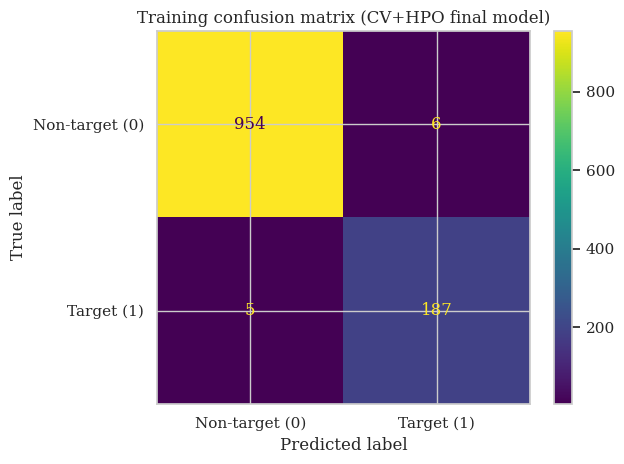

History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_bacc', 'train_bacc_best']


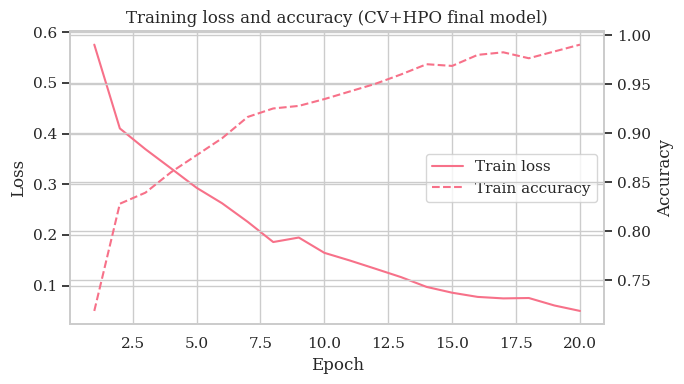

TEST y_true counts: Counter({0: 480, 1: 96})
TEST y_pred counts: Counter({0: 476, 1: 100})


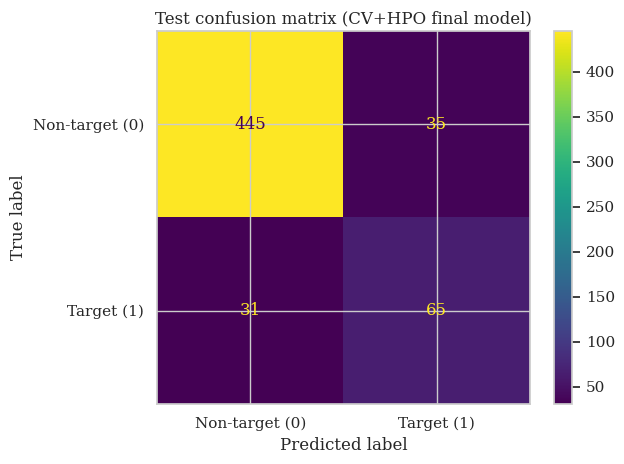

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# choose the model you want to plot for (CV+HPO final refit)
clf = final_clf

# label column (robust)
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"

# TRAIN confusion matrix
y_true_train = meta_train[label_col].to_numpy().astype(int)
y_proba_train = clf.predict_proba(train_set)
y_pred_train = np.argmax(y_proba_train, axis=1)

print("TRAIN y_true counts:", Counter(y_true_train))
print("TRAIN y_pred counts:", Counter(y_pred_train))

cm_train = confusion_matrix(y_true_train, y_pred_train, labels=[0, 1])
ConfusionMatrixDisplay(cm_train, display_labels=["Non-target (0)", "Target (1)"]).plot(values_format="d")
plt.title("Training confusion matrix (CV+HPO final model)")
plt.tight_layout()
plt.show()

# TRAIN loss + accuracy curves (together)

history = pd.DataFrame(clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# accuracy (right axis) if logged
if "train_accuracy" in history.columns:
    ax2 = ax1.twinx()
    ax2.plot(epochs, history["train_accuracy"], linestyle="--", label="Train accuracy")
    ax2.set_ylabel("Accuracy")

    # merged legend
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(l1 + l2, lab1 + lab2, loc="center right")
else:
    ax1.legend(loc="upper right")
    ax1.text(
        0.02, 0.02,
        "train_accuracy not logged (add EpochScoring callback)",
        transform=ax1.transAxes
    )

plt.title("Training loss and accuracy (CV+HPO final model)")
plt.tight_layout()
plt.show()

# 3) TEST confusion matrix
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true_test = meta_test[label_col_test].to_numpy().astype(int)

y_proba_test = clf.predict_proba(test_set)
y_pred_test = np.argmax(y_proba_test, axis=1)

print("TEST y_true counts:", Counter(y_true_test))
print("TEST y_pred counts:", Counter(y_pred_test))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=[0, 1])
ConfusionMatrixDisplay(cm_test, display_labels=["Non-target (0)", "Target (1)"]).plot(values_format="d")
plt.title("Test confusion matrix (CV+HPO final model)")
plt.tight_layout()
plt.show()


History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_bacc', 'train_bacc_best']


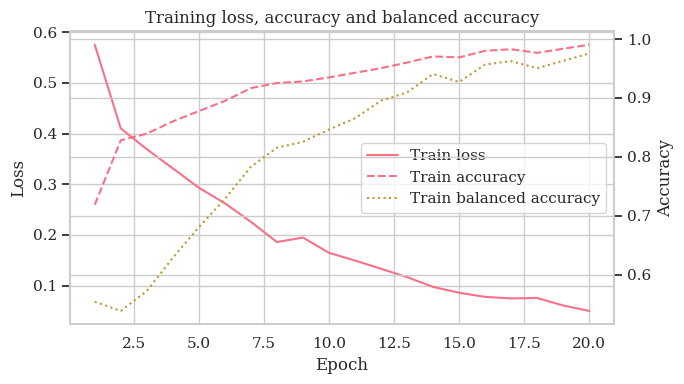

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# Loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Accuracy metrics (right axis)
ax2 = ax1.twinx()

if "train_accuracy" in history.columns:
    ax2.plot(
        epochs,
        history["train_accuracy"],
        linestyle="--",
        label="Train accuracy",
    )

if "train_bacc" in history.columns:
    ax2.plot(
        epochs,
        history["train_bacc"],
        linestyle=":",
        label="Train balanced accuracy",
    )

ax2.set_ylabel("Accuracy")

# Merge legends
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc="center right")

plt.title("Training loss, accuracy and balanced accuracy")
plt.tight_layout()
plt.show()


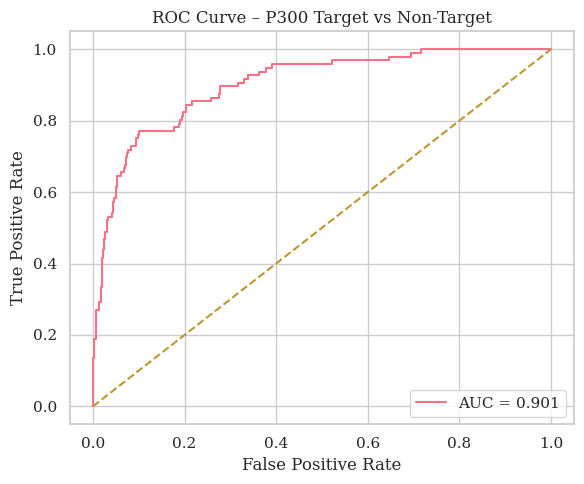

In [37]:
#ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, proba[:, 1])

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – P300 Target vs Non-Target")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


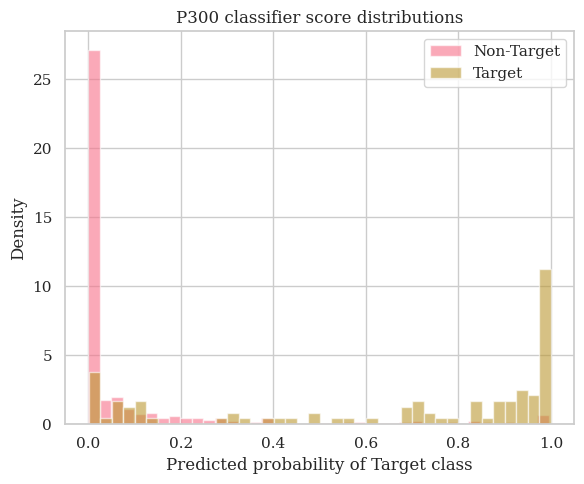

In [38]:
# predicted probability distributions

plt.figure(figsize=(6, 5))

plt.hist(
    proba[y_true == 0, 1],
    bins=40,
    alpha=0.6,
    label="Non-Target",
    density=True,
)

plt.hist(
    proba[y_true == 1, 1],
    bins=40,
    alpha=0.6,
    label="Target",
    density=True,
)

plt.xlabel("Predicted probability of Target class")
plt.ylabel("Density")
plt.title("P300 classifier score distributions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Plot Results (without CV and HPO)

TRAIN y_true counts: Counter({0: 960, 1: 192})
TRAIN y_pred counts: Counter({0: 960, 1: 192})


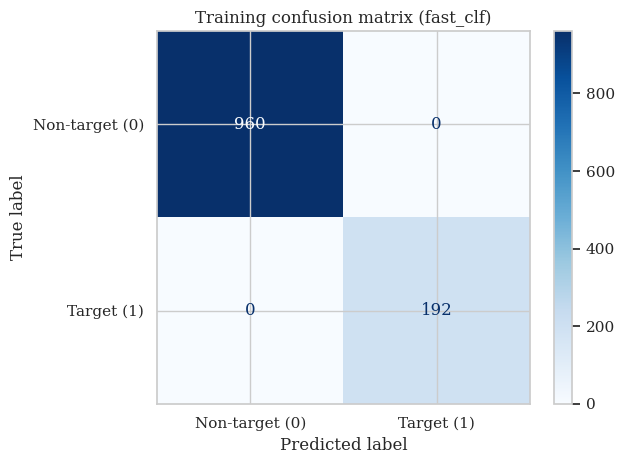

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# true labels from training metadata
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"
y_true_train = meta_train[label_col].to_numpy().astype(int)

# predictions on training set
y_proba_train = fast_clf.predict_proba(train_set)
y_pred_train = np.argmax(y_proba_train, axis=1)

# sanity checks (helps catch class collapse)
print("TRAIN y_true counts:", Counter(y_true_train))
print("TRAIN y_pred counts:", Counter(y_pred_train))

# confusion matrix (force 2x2)
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_train,
    display_labels=["Non-target (0)", "Target (1)"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Training confusion matrix (fast_clf)")
plt.tight_layout()
plt.show()


History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_bacc', 'train_bacc_best']


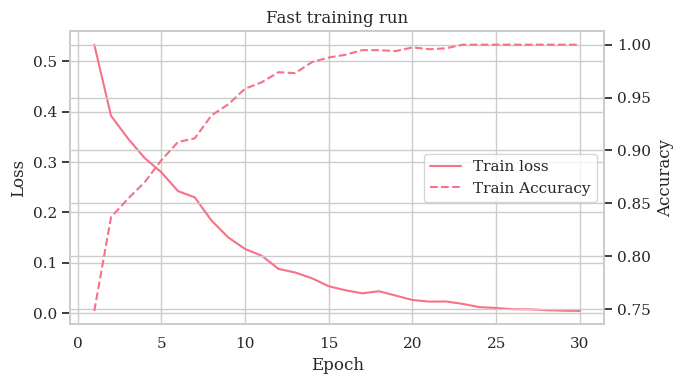

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(clf, title="Training curves"):
    hist = pd.DataFrame(clf.history)
    print("History columns:", list(hist.columns))

    epochs = hist["epoch"]

    fig, ax1 = plt.subplots(figsize=(7, 4))

    # Left axis: loss
    ax1.plot(epochs, hist["train_loss"], label="Train loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # Right axis: accuracy (only if logged)
    acc_cols = [c for c in ["train_accuracy", "valid_accuracy"] if c in hist.columns]
    if acc_cols:
        ax2 = ax1.twinx()
        for c in acc_cols:
            ax2.plot(epochs, hist[c], linestyle="--", label=c.replace("_", " ").title())
        ax2.set_ylabel("Accuracy")

        # Merge legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")
    else:
        ax1.legend(loc="upper right")

    plt.title(title)
    plt.tight_layout()
    plt.show()

# Usage
plot_loss_and_accuracy(fast_clf, title="Fast training run")
# plot_loss_and_accuracy(best_clf, title="Best HPO training run")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(fast_clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# Loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Accuracy metrics (right axis)
ax2 = ax1.twinx()

if "train_accuracy" in history.columns:
    ax2.plot(
        epochs,
        history["train_accuracy"],
        linestyle="--",
        label="Train accuracy",
    )

if "train_bacc" in history.columns:
    ax2.plot(
        epochs,
        history["train_bacc"],
        linestyle=":",
        label="Train balanced accuracy",
    )

ax2.set_ylabel("Accuracy")

# Merge legends
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc="center right")

plt.title("Training loss, accuracy and balanced accuracy (no CV/HPO)")
plt.tight_layout()
plt.show()


y_true counts: Counter({0: 480, 1: 96})
y_pred counts: Counter({0: 501, 1: 75})


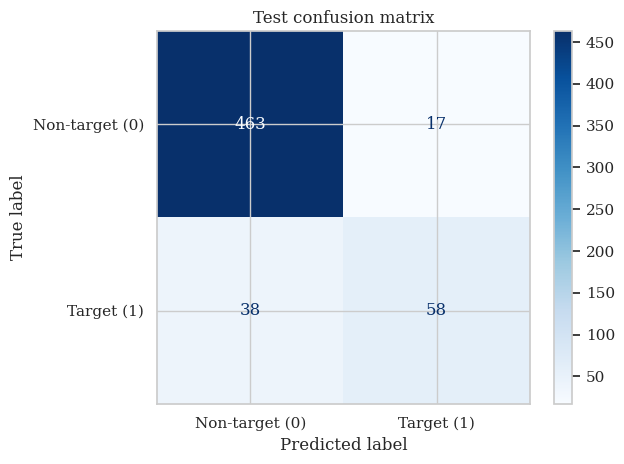

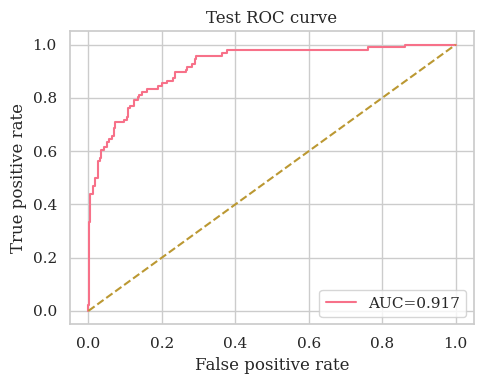

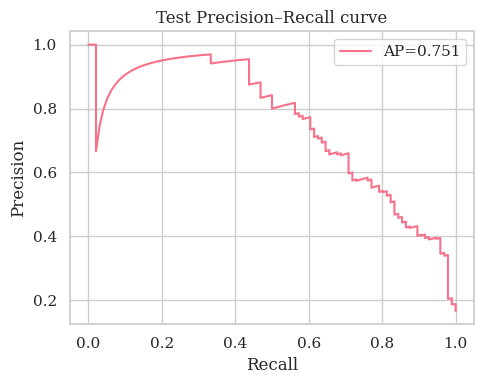

y_true counts: Counter({0: 480, 1: 96})
y_pred counts: Counter({0: 501, 1: 75})


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# extract true labels from test metadata
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy().astype(int)

# model predictions
y_proba = fast_clf.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

# sanity checks (VERY useful)
print("y_true counts:", Counter(y_true))
print("y_pred counts:", Counter(y_pred))

# confusion matrix (force 2x2)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-target (0)", "Target (1)"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Test confusion matrix")
plt.tight_layout()
plt.show()


# ROC curve
if has_both:
    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("Test ROC curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Precision-Recall curve (often more informative for P300 imbalance)
if has_both:
    precision, recall, _ = precision_recall_curve(y_true, y_proba[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Test Precision–Recall curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# sanity prints for the "only two squares filled" confusion matrix issue
from collections import Counter
print("y_true counts:", Counter(y_true))
print("y_pred counts:", Counter(y_pred))

# EEGNet

Adapted from https://braindecode.org/stable/generated/braindecode.models.EEGNet.html
We train the model on the same exact windows and data splits as before but use EEGNet instead. 

### Model from Lawhern et al., 2018

## Infer input dimensions
We try to infer n_chans and n_times from the first window in training set. Braindecode WindowDataset returns (X,y,i) in __getitem__, where X is a torch.Tensor with shape (n_chans, n_times) OR sometimes (1, n_chans, n_times) depending on transforms. 

In [49]:
import torch
import numpy as np

from braindecode.models import EEGNet
from braindecode import EEGClassifier

X0 = train_set[0][0]  # get first window data
if isinstance(X0, np.ndarray):
    X0 = torch.tensor(X0)

# Sometimes people end up with (1, n_chans, n_times) depending on transforms
if X0.ndim == 3 and X0.shape[0] == 1:
    X0 = X0.squeeze(0)

if X0.ndim != 2:
    raise RuntimeError(f"Expected 2D data (n_chans, n_times), got shape: {tuple(X0.shape)}")

n_chans = int(X0.shape[0])
n_times = int(X0.shape[1])

# infer label columns name from metadata
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"
y_train = meta_train[label_col].to_numpy().astype(int)

classes = np.unique(y_train)
n_classes = int(classes.size)

print("Label column:", label_col)
print("Classes found:", classes, "n_classes:", n_classes)
print("EEGNet input dims:", "n_chans =", n_chans, "n_times =", n_times)
print("Train label counts:", Counter(y_train))


Label column: target
Classes found: [0 1] n_classes: 2
EEGNet input dims: n_chans = 16 n_times = 409
Train label counts: Counter({0: 960, 1: 192})


In [ ]:
# set device (check if GPU is available) and seeds (for reproducibility)

cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"

if cuda:
    torch.backends.cudnn.benchmark = True

set_random_seeds(seed=20200220, cuda=cuda)

print("Using device:", device)

Using device: cpu


## Build EEGNet model

In [ ]:
# EEGNet has several architecture paramters
# We keep defaults first -> After you get a baseline, you can tune F1, D, kernel_length, drop_prob, etc.

eegnet_model = EEGNet(
    n_chans=n_chans,
    n_outputs=n_classes,
    n_times=n_times,
    final_conv_length="auto", # infer final layer size
    # pool_mode="mean", # default; you can switch to "max" pooling if you want
    # drop_prob=0.25,   # default dropout probability
).to(device)

print(eegnet_model)


Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGNet (EEGNet)                                              [1, 16, 409]              [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1                                 [1, 16, 409]              [1, 16, 409, 1]           --                        --
├─Rearrange (dimshuffle): 1-2                                [1, 16, 409, 1]           [1, 1, 16, 409]           --                        --
├─Conv2d (conv_temporal): 1-3                                [1, 1, 16, 409]           [1, 8, 16, 410]           512                       [1, 64]
├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 16, 410]           [1, 8, 16, 410]           16                        --
├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 16, 410]           [1, 16, 1, 410]           --                  

## EEGNet fast baseline (no CV, no HPO)

In [52]:
# Fast baseline hyperparams
lr = 1e-3
batch_size = 64
max_epochs = 25

clf_eegnet_fast = EEGClassifier(
    eegnet_model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=lr,
    batch_size=batch_size,
    max_epochs=max_epochs,
    device=device,
    iterator_train__shuffle=True,
    train_split=None,
    classes=list(range(n_classes)),
)

# Fit once on full training set
clf_eegnet_fast.fit(train_set, y=None)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.5383  6.6151
      2        0.4104  4.0895
      3        0.3699  4.7845
      4        0.3338  2.8059
      5        0.2995  3.2676
      6        0.2762  3.5556
      7        0.2459  3.1967
      8        0.2282  4.2364
      9        0.2144  3.4926
     10        0.2065  3.8633
     11        0.1944  3.6355
     12        0.1792  3.2731
     13        0.1824  3.6037
     14        0.1711  13.3938
     15        0.1581  3.5237
     16        0.1513  3.3585
     17        0.1470  2.9269
     18        0.1538  2.6390
     19        0.1348  2.8945
     20        0.1390  2.7910
     21        0.1394  2.5276
     22        0.1395  4.7690
     23        0.1328  3.2499
     24        0.1243  2.7746
     25        0.1328  2.6561


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 16, 409]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 16, 409]              [1, 16, 409, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 16, 409, 1]           [1, 1, 16, 409]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 16, 409]           [1, 8, 16, 410]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 16, 410]           [1, 8, 16, 410]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 16, 410]           [1, 16, 1, 410]           --                        [16, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 16, 1]            256                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 410]           [1, 16, 1, 410]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 410]           [1, 16, 1, 410]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 410]           [1, 16, 1, 102]           --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 102]           [1, 16, 1, 102]           --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 102]           [1, 16, 1, 103]           256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 103]           [1, 16, 1, 103]           256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 103]           [1, 16, 1, 103]           32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 103]           [1, 16, 1, 103]           --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 103]           [1, 16, 1, 12]            --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 12]            [1, 16, 1, 12]            --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 12]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 12]            [1, 2, 1, 1]              386                       [1, 12]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =========================================================================================================

### Evaluate of test set

In [53]:
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

y_proba = clf_eegnet_fast.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_proba[:, 1])
    ap  = average_precision_score(y_true, y_proba[:, 1])
else:
    auc = float("nan")
    ap  = float("nan")

print("EEGNet FAST baseline (test)")
print(f"  accuracy: {acc:.4f}")
print(f"  balanced_accuracy: {bacc:.4f}")
print(f"  roc_auc: {auc:.4f}")
print(f"  avg_precision: {ap:.4f}")

EEGNet FAST baseline (test)
  accuracy: 0.9062
  balanced_accuracy: 0.8313
  roc_auc: 0.9236
  avg_precision: 0.8046


## EEGNet with HPO and CV

In this section we tune EEGNet hyperparamters using optuna. Each optuna trial is evaluated via GroupKFold cross-validation and we optimise mean balanced accuracy across folds.

In [64]:
from sklearn.model_selection import GroupKFold
from torch.utils.data import Subset

def build_eegnet_clf(n_chans, n_times, n_classes, device, lr, batch_size, weight_decay, drop_prob, F1, D, kernel_length, max_epochs):
    # Create a fresh EEGNet + EEGClassifier for a given hyperparameter configuration.
    # We build a new model each time so folds and trials do not leak state.

    model = EEGNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        drop_prob=drop_prob,
        F1=F1,
        D=D,
        kernel_length=kernel_length,
    ).to(device)

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        train_split=None,
        classes=list(range(n_classes)),
    )
    return clf


Trying with optuna -> automated loop that tries hyperparamter combinations and keeps best one (different than one used in ShallowNet). Optuna keeps track of scores and decides what to do next.

In [66]:
import optuna
from sklearn.metrics import balanced_accuracy_score

def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space (moderate ranges for EEGNet)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 1e-3)
    drop_prob = trial.suggest_float("drop_prob", 0.1, 0.6)

    # EEGNet architecture knobs
    F1 = trial.suggest_categorical("F1", [4, 8, 16])
    D = trial.suggest_categorical("D", [1, 2, 4])
    kernel_length = trial.suggest_categorical("kernel_length", [32, 64, 128])

    # Keep epochs smaller for HPO speed
    max_epochs = trial.suggest_int("max_epochs", 10, 25)

    fold_scores = []

    # Loop folds
    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(np.zeros(len(train_set)), y_train, groups)):
        set_random_seeds(seed=2025 + fold_idx, cuda=cuda)

        tr_ds = Subset(train_set, tr_idx)
        va_ds = Subset(train_set, va_idx)

        clf = build_eegnet_clf(
            n_chans=n_chans,
            n_times=n_times,
            n_classes=n_classes,
            device=device,
            lr=lr,
            batch_size=batch_size,
            weight_decay=weight_decay,
            drop_prob=drop_prob,
            F1=F1,
            D=D,
            kernel_length=kernel_length,
            max_epochs=max_epochs,
        )

        clf.fit(tr_ds, y=None)

        # Validation predictions
        y_va_true = y_train[va_idx]
        y_va_proba = clf.predict_proba(va_ds)
        y_va_pred = np.argmax(y_va_proba, axis=1)

        fold_bacc = balanced_accuracy_score(y_va_true, y_va_pred)
        fold_scores.append(fold_bacc)

        # Report intermediate score so Optuna can prune bad trials
        trial.report(np.mean(fold_scores), step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(fold_scores))


Run the HPO

In [67]:
# You can raise n_trials later; start small to verify everything runs
n_trials = 20

sampler = optuna.samplers.TPESampler(seed=2025)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)

study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=n_trials)

print("Best CV score (mean balanced accuracy):", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-12-29 18:36:45,704] A new study created in memory with name: no-name-bac318cf-2a7c-435f-b83b-08eaa0123510


  epoch    train_loss     dur
-------  ------------  ------
      1        0.6993  3.3974
      2        0.5653  3.5539
      3        0.4796  2.4167
      4        0.4391  6.9367
      5        0.4112  6.6445
      6        0.3937  4.8500
      7        0.3744  3.9706
      8        0.3734  6.3306
      9        0.3576  4.9755
     10        0.3521  3.9844
     11        0.3373  3.9394
     12        0.3286  3.5534
     13        0.3178  3.8560
     14        0.3129  3.5345
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6552  3.2827
      2        0.5409  3.0977
      3        0.4701  3.3236
      4        0.4406  3.2573
      5        0.4103  5.0145
      6        0.3963  3.1048
      7        0.3766  3.7485
      8        0.3631  2.7828
      9        0.3576  6.0247
     10        0.3434  6.7473
     11        0.3371  3.2010
     12        0.3200  3.5901
     13        0.3133  13.6822
     14        0.3015  14.7864


[I 2025-12-29 18:39:08,804] Trial 0 finished with value: 0.6817708333333333 and parameters: {'lr': 0.00016989880570601257, 'batch_size': 64, 'weight_decay': 0.0003882355461139826, 'drop_prob': 0.22879821765057948, 'F1': 16, 'D': 4, 'kernel_length': 64, 'max_epochs': 14}. Best is trial 0 with value: 0.6817708333333333.


  epoch    train_loss      dur
-------  ------------  -------
      1        0.5495  22.1414
      2        0.4303  6.3173
      3        0.3892  3.5457
      4        0.3573  2.8097
      5        0.3076  3.1444
      6        0.2869  3.1789
      7        0.2642  3.1043
      8        0.2443  3.3219
      9        0.2410  3.1676
     10        0.2465  2.8461
     11        0.2121  2.7202
     12        0.2140  2.8328
     13        0.1823  2.8367
     14        0.2022  2.6569
     15        0.1941  2.6627
     16        0.1926  2.7708
     17        0.1732  2.6191
     18        0.1875  2.9959
     19        0.2066  2.9580
     20        0.1885  2.7910
     21        0.1770  2.9744
     22        0.1937  3.0161
     23        0.1517  2.9742
     24        0.1725  3.2464
     25        0.1809  2.7709
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5622  3.7061
      2        0.4354  3.3758
      3        0.4388  2.5327
      4        0.4054  2.3315
      5

[I 2025-12-29 18:42:01,168] Trial 1 finished with value: 0.825 and parameters: {'lr': 0.001091252185309859, 'batch_size': 32, 'weight_decay': 0.0006663921049033288, 'drop_prob': 0.5937664554299082, 'F1': 16, 'D': 1, 'kernel_length': 128, 'max_epochs': 25}. Best is trial 1 with value: 0.825.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.4897  3.0122
      2        0.3868  2.5826
      3        0.3443  2.6716
      4        0.3031  2.5650
      5        0.2695  2.5353
      6        0.2271  3.0858
      7        0.2079  2.9500
      8        0.1928  2.6090
      9        0.1669  2.5784
     10        0.1616  2.6146
     11        0.1374  2.7859
     12        0.1361  2.5712
     13        0.1174  2.7169
     14        0.1341  2.6586
     15        0.1181  2.7213
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5002  2.6232
      2        0.3797  2.9006
      3        0.3460  2.7531
      4        0.2973  3.0727
      5        0.2525  2.5833
      6        0.2348  2.5923
      7        0.1950  2.7359
      8        0.1787  2.5764
      9        0.1691  2.8542
     10        0.1749  2.6039
     11        0.1564  2.6895
     12        0.1529  2.6394
     13        0.1444  2.6408
     14        0.1415  2.6831
     15   

[I 2025-12-29 18:43:24,202] Trial 2 finished with value: 0.8229166666666667 and parameters: {'lr': 0.0007444090699380522, 'batch_size': 32, 'weight_decay': 0.0004688992679264961, 'drop_prob': 0.4808865952284338, 'F1': 16, 'D': 4, 'kernel_length': 64, 'max_epochs': 15}. Best is trial 1 with value: 0.825.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.6609  2.3493
      2        0.6281  1.9987
      3        0.6026  1.9615
      4        0.5840  2.0710
      5        0.5482  1.9634
      6        0.5297  1.9951
      7        0.5150  1.9875
      8        0.4942  1.9924
      9        0.4982  2.0518
     10        0.4825  1.9935
     11        0.4580  1.9772
     12        0.4538  1.9992
     13        0.4389  1.9894
     14        0.4245  2.0611
     15        0.4248  1.9895
     16        0.4201  1.9877
     17        0.4196  2.0163
     18        0.4050  1.9823
     19        0.3996  2.0137
     20        0.4051  1.9541
     21        0.4027  1.9316
     22        0.3818  2.0019
     23        0.3857  1.9672
     24        0.3822  2.0621
     25        0.3754  1.9624
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7644  1.9956
      2        0.7197  1.9882
      3        0.6838  1.9843
      4        0.6613  1.9720
      5   

[I 2025-12-29 18:45:04,892] Trial 3 finished with value: 0.6453125 and parameters: {'lr': 0.00015084071966038943, 'batch_size': 128, 'weight_decay': 0.00010386594205539656, 'drop_prob': 0.25587233799723785, 'F1': 16, 'D': 2, 'kernel_length': 64, 'max_epochs': 25}. Best is trial 1 with value: 0.825.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.4859  3.5996
      2        0.3648  2.5943
      3        0.3260  2.4637
      4        0.2904  2.4455
      5        0.2563  3.0521
      6        0.2203  2.4896
      7        0.2195  2.4892
      8        0.1867  2.4032
      9        0.1952  2.4543
     10        0.1695  2.3478
     11        0.1627  2.4234
     12        0.1507  2.3688
     13        0.1339  2.3546
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5373  2.1500
      2        0.3953  2.3429
      3        0.3473  2.3166
      4        0.3174  2.4993
      5        0.2892  2.2901
      6        0.2710  2.1846
      7        0.2445  2.2944
      8        0.2337  2.2526
      9        0.1926  2.1793
     10        0.2062  2.1638
     11        0.1825  2.3427
     12        0.1783  2.2059
     13        0.1610  2.2420


[I 2025-12-29 18:46:09,391] Trial 4 finished with value: 0.7588541666666666 and parameters: {'lr': 0.0013593695260391949, 'batch_size': 32, 'weight_decay': 0.0004413719974441103, 'drop_prob': 0.43639669173830187, 'F1': 16, 'D': 2, 'kernel_length': 64, 'max_epochs': 13}. Best is trial 1 with value: 0.825.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.6741  0.6571
      2        0.5996  0.6077
      3        0.5366  0.5870
      4        0.4926  0.5941
      5        0.4691  0.5995
      6        0.4487  0.6014
      7        0.4549  0.5972
      8        0.4321  0.6492
      9        0.4175  0.5983
     10        0.4213  0.5949
     11        0.3922  0.6020
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6371  0.6042
      2        0.5664  0.6563
      3        0.5137  0.6039
      4        0.4684  0.6266
      5        0.4287  0.6102
      6        0.4068  0.6001
      7        0.4065  0.5962
      8        0.3822  0.6000
      9        0.3716  0.5983
     10        0.3864  0.6344
     11        0.3709  0.6128


[I 2025-12-29 18:46:23,457] Trial 5 pruned. 


  epoch    train_loss     dur
-------  ------------  ------
      1        0.7054  1.6238
      2        0.6908  1.5730
      3        0.6857  1.3004
      4        0.6722  1.7635
      5        0.6577  1.5495
      6        0.6558  1.2632
      7        0.6462  1.9595
      8        0.6325  1.2908
      9        0.6292  1.9838
     10        0.6246  1.4732
     11        0.6122  1.7758
     12        0.5979  1.5116
     13        0.5958  1.2734
     14        0.5976  1.8594
     15        0.5899  1.3316
     16        0.5893  1.8348
     17        0.5747  1.5193
     18        0.5734  1.5029
     19        0.5633  1.6017
     20        0.5561  1.6405
     21        0.5558  1.5186
     22        0.5464  1.6071
     23        0.5447  1.5775
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7010  1.5302
      2        0.6817  1.2983
      3        0.6666  1.8806
      4        0.6389  3.9096
      5        0.6331  3.1564
      6        0.6066  1.5907
      7   

[I 2025-12-29 18:47:53,113] Trial 6 pruned. 


  epoch    train_loss     dur
-------  ------------  ------
      1        0.6794  0.8087
      2        0.6235  0.7752
      3        0.5756  0.7088
      4        0.5416  0.8458
      5        0.4997  0.7973
      6        0.4827  1.5868
      7        0.4630  0.9504
      8        0.4533  0.7997
      9        0.4407  0.7524
     10        0.4354  1.1570
     11        0.4134  1.8129
     12        0.4062  1.1285
     13        0.4101  1.9267
     14        0.3962  1.5173
     15        0.3868  1.2101
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6355  1.4863
      2        0.5809  1.1908
      3        0.5495  1.9096
      4        0.5086  1.7211
      5        0.4820  1.5855
      6        0.4554  0.7836
      7        0.4369  0.7568
      8        0.4216  0.6951
      9        0.4069  0.7033
     10        0.3954  0.8564
     11        0.3781  0.7375
     12        0.3853  0.9025
     13        0.3768  0.7717
     14        0.3539  0.8168
     15   

[I 2025-12-29 18:48:26,659] Trial 7 pruned. 


  epoch    train_loss     dur
-------  ------------  ------
      1        0.6816  1.4468
      2        0.5896  1.1840
      3        0.5265  1.6677
      4        0.4872  1.1391
      5        0.4573  1.8421
      6        0.4360  1.4716
      7        0.4188  1.1453
      8        0.4118  1.7868
      9        0.3984  1.4065
     10        0.3858  1.1329
     11        0.3716  1.6634
     12        0.3735  1.4268
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6152  1.3813
      2        0.5325  1.5409
      3        0.4817  1.4692
      4        0.4569  1.1671
      5        0.4307  1.6704
      6        0.4296  1.1375
      7        0.4163  2.2130
      8        0.3982  1.8748
      9        0.3879  1.2250
     10        0.3781  1.8400
     11        0.3797  1.1681
     12        0.3852  2.3158


[I 2025-12-29 18:49:04,049] Trial 8 pruned. 


  epoch    train_loss     dur
-------  ------------  ------
      1        0.6287  1.4877
      2        0.5390  1.1933
      3        0.5009  1.7702
      4        0.4758  1.1650
      5        0.4491  1.7087
      6        0.4374  1.1575
      7        0.4230  1.6683
      8        0.4156  1.1375
      9        0.3966  1.7534
     10        0.3851  1.5317
     11        0.3803  1.5471
     12        0.3797  1.1469
     13        0.3668  1.7914
     14        0.3494  1.4466
     15        0.3483  1.4680
     16        0.3381  1.1483
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6653  1.4697
      2        0.5869  1.5050
      3        0.5393  2.2040
      4        0.4923  1.4475
      5        0.4500  1.1567
      6        0.4264  1.8709
      7        0.4049  1.5823
      8        0.3900  1.5357
      9        0.3769  1.4601
     10        0.3576  1.1633
     11        0.3506  1.7548
     12        0.3330  1.1416
     13        0.3272  1.7507
     14   

[I 2025-12-29 18:49:52,920] Trial 9 pruned. 


  epoch    train_loss     dur
-------  ------------  ------
      1        0.5399  1.9694
      2        0.4093  1.9988
      3        0.3880  2.0747
      4        0.3690  1.9310
      5        0.3489  1.9537
      6        0.3049  2.0730
      7        0.3272  1.9662
      8        0.2833  1.9952
      9        0.2534  1.9373
     10        0.2568  1.9449
     11        0.2765  1.9721
     12        0.2792  2.1259
     13        0.2635  2.0359
     14        0.2548  2.0426
     15        0.2226  1.9771
     16        0.2644  1.9766
     17        0.2531  1.9043
     18        0.2200  2.0242
     19        0.2364  2.4339
     20        0.2182  1.9475
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5322  1.9688
      2        0.4063  1.9077
      3        0.4187  2.0148
      4        0.3848  2.1380
      5        0.3478  2.0958
      6        0.3200  1.9551
      7        0.3174  1.9622
      8        0.2910  2.4469
      9        0.2846  1.8943
     10   

[I 2025-12-29 18:51:13,864] Trial 10 finished with value: 0.7208333333333333 and parameters: {'lr': 0.004762705283913937, 'batch_size': 32, 'weight_decay': 0.0007728029585614394, 'drop_prob': 0.5997512706990032, 'F1': 8, 'D': 1, 'kernel_length': 128, 'max_epochs': 20}. Best is trial 1 with value: 0.825.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.5470  2.4597
      2        0.4230  2.5905
      3        0.3997  2.5751
      4        0.3686  2.4912
      5        0.3529  2.4936
      6        0.3244  2.4314
      7        0.3071  2.5127
      8        0.2851  2.3929
      9        0.2619  2.4384
     10        0.2445  2.4736
     11        0.2170  2.5214
     12        0.2205  2.4329
     13        0.1811  2.4527
     14        0.1837  2.4584
     15        0.1749  2.5045
     16        0.1749  2.4070
     17        0.1621  2.4016
     18        0.1512  2.3977
     19        0.1465  2.4298
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5369  2.3768
      2        0.4157  2.4387
      3        0.4005  2.4280
      4        0.3711  2.5090
      5        0.3480  2.4404
      6        0.3236  2.4137
      7        0.2832  2.4915
      8        0.2576  2.5071
      9        0.2387  2.4459
     10        0.2250  2.3994
     11   

[I 2025-12-29 18:52:49,324] Trial 11 finished with value: 0.83125 and parameters: {'lr': 0.00048790266683520226, 'batch_size': 32, 'weight_decay': 0.0006154091005510669, 'drop_prob': 0.5887594778854673, 'F1': 16, 'D': 4, 'kernel_length': 64, 'max_epochs': 19}. Best is trial 11 with value: 0.83125.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.5127  3.0603
      2        0.4077  3.0031
      3        0.3804  3.0032
      4        0.3530  2.9740
      5        0.3304  3.0340
      6        0.3113  3.0024
      7        0.2990  2.9974
      8        0.2799  3.0302
      9        0.2586  2.9372
     10        0.2520  3.1023
     11        0.2325  2.9967
     12        0.2370  3.0289
     13        0.2055  2.9808
     14        0.1882  2.9910
     15        0.1898  3.0791
     16        0.1859  3.0152
     17        0.1830  3.0114
     18        0.1774  3.0991
     19        0.1569  2.9746
     20        0.1511  3.0598
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5806  2.9568
      2        0.4194  2.9116
      3        0.3842  2.9535
      4        0.3537  2.9270
      5        0.3377  3.0092
      6        0.3051  2.8999
      7        0.2926  2.8968
      8        0.2713  2.9933
      9        0.2582  2.9247
     10   

[I 2025-12-29 18:54:50,486] Trial 12 finished with value: 0.8364583333333333 and parameters: {'lr': 0.00038115095308110847, 'batch_size': 32, 'weight_decay': 0.0009827616063746167, 'drop_prob': 0.5793727335053004, 'F1': 16, 'D': 4, 'kernel_length': 128, 'max_epochs': 20}. Best is trial 12 with value: 0.8364583333333333.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.5672  2.5510
      2        0.4234  2.7152
      3        0.3941  2.4949
      4        0.3573  2.4709
      5        0.3463  2.5397
      6        0.3237  2.6736
      7        0.3038  2.4532
      8        0.2874  2.5238
      9        0.2634  2.4587
     10        0.2469  2.5451
     11        0.2198  2.7483
     12        0.2073  2.5802
     13        0.1865  2.5441
     14        0.1854  2.5943
     15        0.1712  2.5012
     16        0.1630  2.5326
     17        0.1538  2.4239
     18        0.1528  2.5420
     19        0.1469  2.4871
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5546  2.4852
      2        0.4192  2.4654
      3        0.4036  2.7301
      4        0.3729  2.6976
      5        0.3483  2.4048
      6        0.3287  2.4117
      7        0.2954  2.5174
      8        0.2729  2.4286
      9        0.2409  2.4300
     10        0.2310  2.3719
     11   

[I 2025-12-29 18:56:27,281] Trial 13 finished with value: 0.8130208333333333 and parameters: {'lr': 0.0003622843352419015, 'batch_size': 32, 'weight_decay': 0.00098610911973142, 'drop_prob': 0.485025240361011, 'F1': 16, 'D': 4, 'kernel_length': 64, 'max_epochs': 19}. Best is trial 12 with value: 0.8364583333333333.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.5047  2.9916
      2        0.4040  3.0226
      3        0.3685  3.1525
      4        0.3449  3.0784
      5        0.3193  2.9964
      6        0.3034  2.9518
      7        0.2740  3.1846
      8        0.2592  2.9393
      9        0.2358  2.9912
     10        0.2341  3.0546
     11        0.2160  3.0139
     12        0.2114  2.9510
     13        0.1847  2.9632
     14        0.1639  3.2276
     15        0.1668  3.0276
     16        0.1637  2.9118
     17        0.1655  3.9757
     18        0.1579  3.0745
     19        0.1422  2.9697
     20        0.1354  3.0953
     21        0.1248  2.9926
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5739  2.8972
      2        0.4117  3.0433
      3        0.3683  2.9689
      4        0.3416  2.9592
      5        0.3226  2.9682
      6        0.2930  3.1358
      7        0.2776  2.9609
      8        0.2509  2.9519
      9   

[I 2025-12-29 18:58:35,626] Trial 14 finished with value: 0.846875 and parameters: {'lr': 0.00038809762950116534, 'batch_size': 32, 'weight_decay': 0.000997517836738623, 'drop_prob': 0.530710204487765, 'F1': 16, 'D': 4, 'kernel_length': 128, 'max_epochs': 21}. Best is trial 14 with value: 0.846875.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.5118  2.9999
      2        0.4065  2.8318
      3        0.3721  2.9597
      4        0.3491  2.9905
      5        0.3238  3.0773
      6        0.3061  2.9143
      7        0.2829  2.9166
      8        0.2665  2.9171
      9        0.2480  3.0112
     10        0.2413  2.9552
     11        0.2246  2.8969
     12        0.2145  3.0266
     13        0.1931  2.9210
     14        0.1696  2.9838
     15        0.1749  3.1560
     16        0.1681  2.9541
     17        0.1711  2.9015
     18        0.1603  2.8517
     19        0.1449  2.9864
     20        0.1385  2.9056
     21        0.1288  2.9413
     22        0.1396  3.0367
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5806  2.8549
      2        0.4162  2.9298
      3        0.3692  3.0787
      4        0.3446  2.9322
      5        0.3260  2.9853
      6        0.2987  2.8902
      7        0.2849  2.9583
      8   

[I 2025-12-29 19:00:47,875] Trial 15 finished with value: 0.8401041666666667 and parameters: {'lr': 0.0003540792146260347, 'batch_size': 32, 'weight_decay': 0.0009679005670241451, 'drop_prob': 0.5152886814692946, 'F1': 16, 'D': 4, 'kernel_length': 128, 'max_epochs': 22}. Best is trial 14 with value: 0.846875.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.6675  2.1372
      2        0.5656  2.2916
      3        0.5072  2.0685
      4        0.4663  3.6912
      5        0.4334  3.0091
      6        0.4203  2.3826
      7        0.4027  2.0714
      8        0.3933  2.1860
      9        0.3862  2.0024
     10        0.3714  2.0097
     11        0.3590  2.2287
     12        0.3552  141.2647
     13        0.3526  4.6823
     14        0.3422  4.7206
     15        0.3258  6.2109
     16        0.3263  3.9370
     17        0.3083  3.0194
     18        0.3126  2.9213
     19        0.3041  2.8867
     20        0.2982  2.5432
     21        0.2791  2.5743
     22        0.2796  2.5653
     23        0.2694  2.5569
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6654  2.4514
      2        0.5553  2.8697
      3        0.4997  2.9766
      4        0.4597  2.7205
      5        0.4135  2.8033
      6        0.4099  2.5017
      7 

[I 2025-12-29 19:05:09,448] Trial 16 pruned. 


  epoch    train_loss     dur
-------  ------------  ------
      1        0.4804  3.0843
      2        0.3834  3.1122
      3        0.3440  3.1447
      4        0.3229  3.1842
      5        0.2908  3.0988
      6        0.2728  3.0754
      7        0.2386  3.9152
      8        0.2140  4.3129
      9        0.1964  3.1751
     10        0.1882  3.1973
     11        0.1785  3.1132
     12        0.1776  3.1870
     13        0.1508  3.2219
     14        0.1367  3.1916
     15        0.1441  3.1310
     16        0.1374  3.3352
     17        0.1420  3.4255
     18        0.1319  3.2436
     19        0.1164  3.2980
     20        0.1090  3.4159
     21        0.0948  3.1746
     22        0.1156  3.2265
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5368  3.0378
      2        0.3873  3.1411
      3        0.3417  4.6685
      4        0.3114  3.4476
      5        0.2872  3.1073
      6        0.2507  3.1284
      7        0.2305  3.0488
      8   

[I 2025-12-29 19:07:36,202] Trial 17 finished with value: 0.8364583333333333 and parameters: {'lr': 0.0005377144145579355, 'batch_size': 32, 'weight_decay': 0.0008689680186696199, 'drop_prob': 0.5192152654038741, 'F1': 16, 'D': 4, 'kernel_length': 128, 'max_epochs': 22}. Best is trial 14 with value: 0.846875.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.5272  3.1459
      2        0.4159  2.9654
      3        0.3751  3.1909
      4        0.3535  3.1502
      5        0.3294  3.1108
      6        0.3096  3.1353
      7        0.2923  3.0951
      8        0.2767  3.0784
      9        0.2619  3.2861
     10        0.2478  3.0668
     11        0.2396  3.1091
     12        0.2196  3.1524
     13        0.2056  3.0965
     14        0.1910  3.1084
     15        0.1711  3.1815
     16        0.1748  3.0541
     17        0.1735  3.1001
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6082  3.7651
      2        0.4347  3.2722
      3        0.3769  3.1065
      4        0.3459  3.2015
      5        0.3342  3.1277
      6        0.3027  3.1527
      7        0.2894  3.1186
      8        0.2733  3.2166
      9        0.2597  3.1248
     10        0.2378  3.3347
     11        0.2179  3.2652
     12        0.2147  3.1496
     13   

[I 2025-12-29 19:09:26,353] Trial 18 finished with value: 0.8182291666666667 and parameters: {'lr': 0.0002450004009549718, 'batch_size': 32, 'weight_decay': 0.000600304024181964, 'drop_prob': 0.38156696542835916, 'F1': 16, 'D': 4, 'kernel_length': 128, 'max_epochs': 17}. Best is trial 14 with value: 0.846875.


  epoch    train_loss     dur
-------  ------------  ------
      1        0.7008  2.1537
      2        0.6538  2.2267
      3        0.6252  2.2501
      4        0.5967  2.2599
      5        0.5696  2.1642
      6        0.5504  2.1977
      7        0.5222  2.2387
      8        0.5072  2.5831
      9        0.5005  3.3092
     10        0.4817  2.9089
     11        0.4704  2.3391
     12        0.4574  2.4195
     13        0.4594  2.3140
     14        0.4454  2.2661
     15        0.4344  2.2816
     16        0.4388  2.3148
     17        0.4301  2.3261
     18        0.4287  2.3068
     19        0.4167  2.2881
     20        0.4168  2.2707
     21        0.4032  2.3439
     22        0.4113  2.3258
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6933  2.1867
      2        0.6554  2.2195
      3        0.6188  2.3980
      4        0.5958  2.3530
      5        0.5420  2.3780
      6        0.5342  2.2725
      7        0.5132  2.2033
      8   

[I 2025-12-29 19:11:11,680] Trial 19 pruned. 


Best CV score (mean balanced accuracy): 0.846875
Best hyperparameters:
  lr: 0.00038809762950116534
  batch_size: 32
  weight_decay: 0.000997517836738623
  drop_prob: 0.530710204487765
  F1: 16
  D: 4
  kernel_length: 128
  max_epochs: 21


### Refit best EEGNet on full training set and evaluate on test set

In [68]:
best = study.best_params

# Build final clf using best params
set_random_seeds(seed=2025, cuda=torch.cuda.is_available())

final_clf_eegnet = build_eegnet_clf(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=best["lr"],
    batch_size=best["batch_size"],
    weight_decay=best["weight_decay"],
    drop_prob=best["drop_prob"],
    F1=best["F1"],
    D=best["D"],
    kernel_length=best["kernel_length"],
    max_epochs=best["max_epochs"],
)

final_clf_eegnet.fit(train_set, y=None)

# Test evaluation
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

y_proba = final_clf_eegnet.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_proba[:, 1])
    ap  = average_precision_score(y_true, y_proba[:, 1])
else:
    auc = float("nan")
    ap  = float("nan")

print("EEGNet HPO+CV (test)")
print(f"  accuracy: {acc:.4f}")
print(f"  balanced_accuracy: {bacc:.4f}")
print(f"  roc_auc: {auc:.4f}")
print(f"  avg_precision: {ap:.4f}")


  epoch    train_loss     dur
-------  ------------  ------
      1        0.4625  7.5906
      2        0.3706  6.6762
      3        0.3276  5.8477
      4        0.2988  5.5355
      5        0.2600  5.6756
      6        0.2402  5.7090
      7        0.2221  5.7922
      8        0.1970  5.7561
      9        0.1907  7.2807
     10        0.1721  7.0028
     11        0.1734  6.7070
     12        0.1547  6.2873
     13        0.1582  6.3238
     14        0.1392  6.2591
     15        0.1428  6.8379
     16        0.1530  6.2294
     17        0.1431  6.1585
     18        0.1365  6.0073
     19        0.1415  6.1433
     20        0.1345  6.0044
     21        0.1222  6.2877
EEGNet HPO+CV (test)
  accuracy: 0.8993
  balanced_accuracy: 0.8604
  roc_auc: 0.9227
  avg_precision: 0.7879
